In [1]:
from model_training.Model import RNNModel
from model_training.Trainer import RNNTrainer
from model_training.Dataset import NavigationDataset
import torch
import pandas as pd
from data_generation.Environment import Environment
from data_generation.Agent import Agent
import matplotlib.pyplot as plt
import pickle



In [ ]:



data = pd.read_csv("data/data_sample.csv")
data.rename(columns={'angle': 'direction'}, inplace=True)

dataset = NavigationDataset(data)
dataloader = dataset.get_dataloader(batch_size=64, shuffle=True)
dataloader_iter = iter(dataloader)
batch = next(dataloader_iter)
model = RNNModel()
trainer = RNNTrainer(model, device="cuda" if torch.cuda.is_available() else "cpu")
trainer.train(dataloader, n_epochs=1000, verbose=True)


In [ ]:
model.to("cpu")
with open("models/rnn_model.pkl", "wb") as f:
    pickle.dump(model, f)

   step  direction     speed         x         y  collision
0     0   0.000000  0.000000  0.000000  0.000000      False
1     1   4.991632  0.474421  0.130764 -0.456044      False
2     2   4.939390  0.474421  0.237535 -0.918295      False
3     3   4.939390  0.474421  0.344307 -1.380545      False
4     4   2.934268  0.474421 -0.119955 -1.282889      False


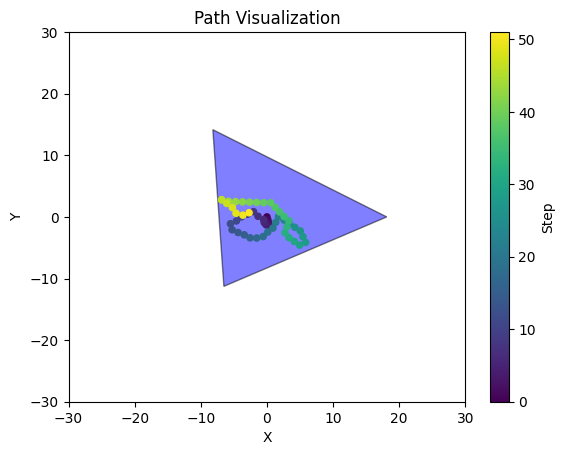

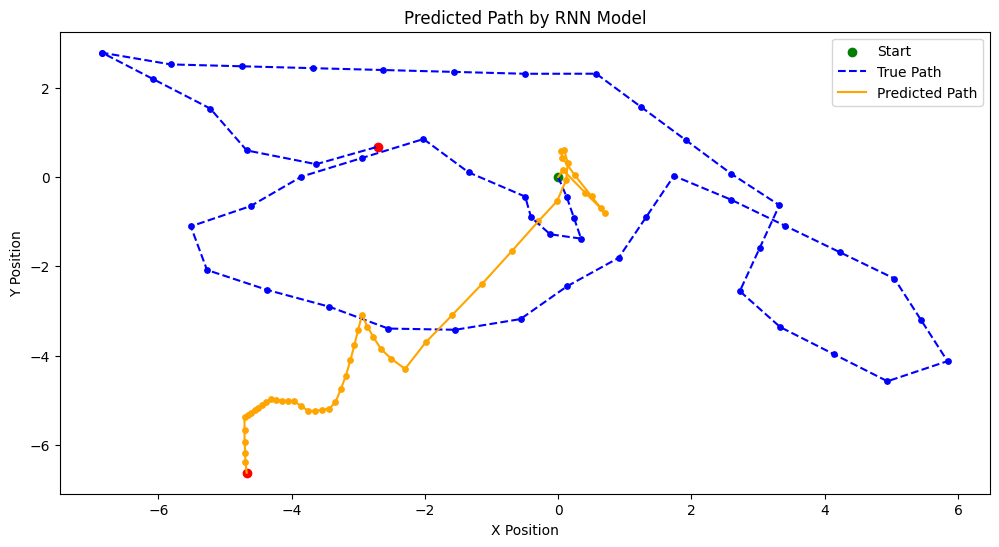

In [15]:
with open("models/rnn_model.pkl", "rb") as f:
    model = pickle.load(f)

env = Environment(3, 10, 20)
agent = Agent(env)
for _ in range(51):
    agent.step(1)

path = agent.get_data()
print(path.head())
path['run_id'] = 0
data = NavigationDataset(path)
dataloader = data.get_dataloader(batch_size=1)


# predict the sample data
model.eval()
outputs = []
with torch.no_grad():
    for batch in dataloader:
        X, Y, lengths, run_ids = batch
        X = X[0]
        Y = Y[0]
        lengths = lengths[0]
        activations, outputs = model(X, lengths)
        break


agent.visualize_path()
# visualize the true path and predicted path

pred_path = outputs.numpy()
true_path = Y.numpy()
plt.figure(figsize=(12, 6))
plt.scatter(pred_path[0, 0], pred_path[0, 1], color='green', label='Start')
plt.plot(true_path[:, 0], true_path[:, 1], label='True Path', color='blue', linestyle='--')
plt.scatter(true_path[1:, 0], true_path[1:, 1], color='blue', s=15)
plt.plot(pred_path[:, 0], pred_path[:, 1], label='Predicted Path', color='orange')
plt.scatter(pred_path[1:, 0], pred_path[1:, 1], color='orange', s=15)
plt.scatter(pred_path[-1, 0], pred_path[-1, 1], color='red')
plt.scatter(true_path[-1, 0], true_path[-1, 1], color='red')
plt.title('Predicted Path by RNN Model')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()

